#***`IMPORT`***

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#***`MOUNT DRIVE`***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#***`PATH`***

In [ ]:
# Paths and parameters
DATA_DIR = "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 15   # epochs for initial head training
EPOCHS_FINE = 25   # epochs for fine-tuning
CLASS_NAMES = ["Immature", "Mature", "Normal"]
SAVE_DIR = "/content/drive/MyDrive/PROJECT1/trained models/"
os.makedirs(SAVE_DIR, exist_ok=True)

#***`DATA GENERATORS`***

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [ ]:

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_data = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "valid"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_data.class_indices)

Found 3712 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Class indices: {'Immature': 0, 'Mature': 1, 'Normal': 2}


#*```COMPUTE CLASS WEIGHTS```*

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0998518518518519), 1: np.float64(0.9644063393089114), 2: np.float64(0.9488752556237219)}


#*```LOADING MODEL WITHOUT TOP LAYERS```*

In [ ]:
# Load VGG19 base model without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # Freeze all layers initially

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#*``` ADD CLASSIFICATION HEADEER```*

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#*```COMPILE FOR HEAD TRAINING```*

In [ ]:

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#*```CALLBACKS FOR TRAINING```*

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint_path = os.path.join(SAVE_DIR, "vgg19_best_model.h5")
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# ***`Stage 1: Training classification head`***

In [ ]:
history1 = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=[es, rlr, mc]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6214 - loss: 11.4494
Epoch 1: val_loss improved from inf to 1.19653, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 993s 8s/step - accuracy: 0.6225 - loss: 11.4061 - val_accuracy: 0.9345 - val_loss: 1.1965 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8961 - loss: 2.0194
Epoch 2: val_loss did not improve from 1.19653
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 444ms/step - accuracy: 0.8961 - loss: 2.0201 - val_accuracy: 0.9402 - val_loss: 1.2794 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9256 - loss: 1.8885
Epoch 3: val_loss improved from 1.19653 to 0.24909, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.9256 - loss: 1.8874 - val_accuracy: 0.9895 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9468 - loss: 1.2358
Epoch 4: val_loss improved from 0.24909 to 0.12830, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 465ms/step - accuracy: 0.9468 - loss: 1.2368 - val_accuracy: 0.9919 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9504 - loss: 1.3392
Epoch 5: val_loss did not improve from 0.12830
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 452ms/step - accuracy: 0.9504 - loss: 1.3387 - val_accuracy: 0.9863 - val_loss: 0.1797 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9484 - loss: 1.7455
Epoch 6: val_loss did not improve from 0.12830
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 444ms/step - accuracy: 0.9484 - loss: 1.7456 - val_accuracy: 0.9887 - val_loss: 0.1397 - learning_rate: 0.0010
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9433 - loss: 1.9982
Epoch 7: val_loss improved from 0.12830 to 0.12438, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - accuracy: 0.9434 - loss: 1.9940 - val_accuracy: 0.9943 - val_loss: 0.1244 - learning_rate: 0.0010
Epoch 8/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9735 - loss: 0.9249
Epoch 8: val_loss improved from 0.12438 to 0.08358, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - accuracy: 0.9735 - loss: 0.9261 - val_accuracy: 0.9935 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 9/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9707 - loss: 0.7558
Epoch 9: val_loss improved from 0.08358 to 0.03231, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 467ms/step - accuracy: 0.9707 - loss: 0.7572 - val_accuracy: 0.9984 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 10/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9698 - loss: 1.1214
Epoch 10: val_loss did not improve from 0.03231
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - accuracy: 0.9698 - loss: 1.1214 - val_accuracy: 0.9968 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 11/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9659 - loss: 1.2381
Epoch 11: val_loss did not improve from 0.03231
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 444ms/step - accuracy: 0.9659 - loss: 1.2390 - val_accuracy: 0.9903 - val_loss: 0.2407 - learning_rate: 0.0010
Epoch 12/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9781 - loss: 0.8754
Epoch 12: val_loss did not improve from 0.03231
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 448ms/step - accuracy: 0.9780 - loss: 0.8761 - val_accuracy: 0.9968 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 13/15
1

# Unfreeze last convolutional block of base_model for fine-tuning

In [ ]:

for layer in base_model.layers:
    layer.trainable = layer.name.startswith("block5")

# Recompile with lower learning rate for fine-tuning

In [ ]:


model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Stage 2: Fine-tuning last layers

In [ ]:
history2 = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=[es, rlr, mc]
)

Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9710 - loss: 0.8243
Epoch 1: val_loss improved from 0.03231 to 0.02317, saving model to /content/drive/MyDrive/PROJECT1/trained models/vgg19_best_model.h5


116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 477ms/step - accuracy: 0.9710 - loss: 0.8235 - val_accuracy: 0.9984 - val_loss: 0.0232 - learning_rate: 1.0000e-05
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9876 - loss: 0.2876
Epoch 2: val_loss did not improve from 0.02317
116/116 ━━━━━━━━━━━━━━━━━━━━ 57s 488ms/step - accuracy: 0.9876 - loss: 0.2884 - val_accuracy: 0.9968 - val_loss: 0.0425 - learning_rate: 1.0000e-05
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9885 - loss: 0.1756
Epoch 3: val_loss did not improve from 0.02317
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 448ms/step - accuracy: 0.9885 - loss: 0.1755 - val_accuracy: 0.9984 - val_loss: 0.0670 - learning_rate: 1.0000e-05
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9935 - loss: 0.1334
Epoch 4: val_loss did not improve from 0.02317
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 445ms/step - accuracy: 0.9935 - loss: 0.1337 - val_accuracy: 0.9976 - val_loss: 0.0924 - learning_rate: 1.0000e-05
Epo

In [ ]:
# Combine histories
def combine_histories(h1, h2):
    history = {}
    for k in h1.history.keys():
        history[k] = h1.history[k] + h2.history[k]
    return history

full_history = combine_histories(history1, history2)

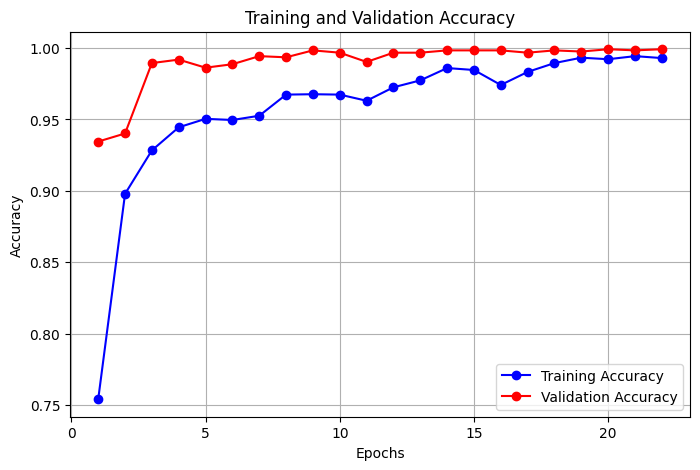

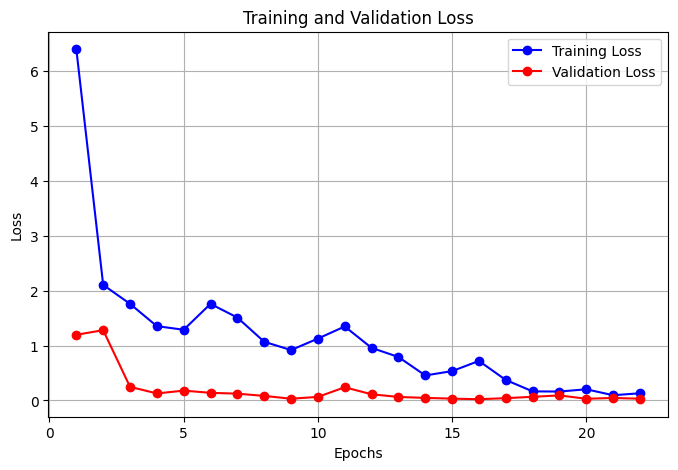

In [ ]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(full_history)

In [ ]:

# Final evaluation
print("Evaluating on test set")
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

Evaluating on test set
39/39 ━━━━━━━━━━━━━━━━━━━━ 308s 8s/step - accuracy: 1.0000 - loss: 1.1484e-06
Test Accuracy: 1.00


39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step
Classification Report:
              precision    recall  f1-score   support

    Immature       1.00      1.00      1.00       368
      Mature       1.00      1.00      1.00       421
      Normal       1.00      1.00      1.00       448

    accuracy                           1.00      1237
   macro avg       1.00      1.00      1.00      1237
weighted avg       1.00      1.00      1.00      1237



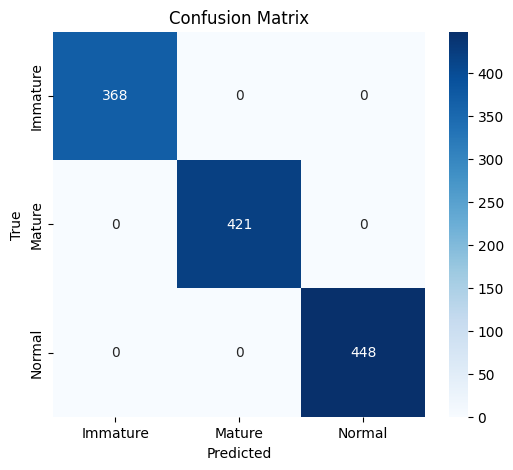

In [ ]:
# Classification report and confusion matrix
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = test_acc * 100
accuracy_str = f"{accuracy:.2f}".replace('.', '_')
model_name_h5 = f"vgg19_{accuracy_str}.h5"
model_name_keras = f"vgg19_{accuracy_str}.keras"

model.save(os.path.join(SAVE_DIR, model_name_h5))
model.save(os.path.join(SAVE_DIR, model_name_keras))

print(f"Models saved as: {model_name_h5}, {model_name_keras}")



Models saved as: vgg19_100_00.h5, vgg19_100_00.keras
